In [1]:
!pip install pytorch_msssim

In [2]:

import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
from torch.amp import autocast
from skimage.metrics import peak_signal_noise_ratio
from torchvision.models import vgg16
from pytorch_msssim import SSIM
import torchvision.transforms as transforms

In [3]:

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
model_path = '/content/drive/MyDrive/bimsaae_checkpoints/bimsaae_final.pth'
input_video_path = '/content/drive/MyDrive/cleanvideo.mp4'  # Adjust path to your video
output_dir = '/content/drive/MyDrive/denoising_video_samples'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# BiMSAAE Model for Grayscale
class MultiScaleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(1, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(1, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True)
        )
        self.residual = nn.Conv2d(1, 252, kernel_size=1)
        self.checkpoint_segments = 2

    def forward(self, x):
        f1 = self.branch3x3(x)
        f2 = self.branch5x5(x)
        res = self.residual(x)
        return torch.cat([f1, f2], dim=1) + res

class NoiseGateModule(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mask = self.conv(x)
        mask = self.sigmoid(mask)
        return x * mask

class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)
        max_out = self.max_pool(x)
        pooled = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv(pooled)
        attn = self.sigmoid(attn)
        return x * attn

class DualHeadDecoder(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.structural_head = nn.Sequential(
            nn.Conv2d(in_channels, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 63, kernel_size=3, padding=1),
            nn.BatchNorm2d(63),
            nn.ReLU(inplace=True),
            nn.Conv2d(63, 33, kernel_size=3, padding=1),
            nn.BatchNorm2d(33),
            nn.ReLU(inplace=True),
            nn.Conv2d(33, 15, kernel_size=3, padding=1),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )
        self.texture_head = nn.Sequential(
            nn.Conv2d(in_channels, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 63, kernel_size=5, padding=2),
            nn.BatchNorm2d(63),
            nn.ReLU(inplace=True),
            nn.Conv2d(63, 33, kernel_size=5, padding=2),
            nn.BatchNorm2d(33),
            nn.ReLU(inplace=True),
            nn.Conv2d(33, 15, kernel_size=5, padding=2),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1)
        )
        self.alpha = nn.Parameter(torch.tensor(0.6))
        self.checkpoint_segments = 2

    def forward(self, x):
        struct = self.structural_head(x)
        text = self.texture_head(x)
        return self.alpha * struct + (1 - self.alpha) * text

class SharpeningModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        laplacian = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]], dtype=torch.float32)
        self.conv.weight = nn.Parameter(laplacian)
        self.strength = nn.Parameter(torch.tensor(0.7))

    def forward(self, x):
        edges = self.conv(x)
        return x + self.strength * edges

class BiMSAAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MultiScaleEncoder()
        self.noise_gate = NoiseGateModule()
        self.attention = ChannelAttentionBlock()
        self.decoder = DualHeadDecoder()
        self.sharpen = SharpeningModule()
        self.skip_conv = nn.Conv2d(252, 252, kernel_size=1)

    def forward(self, x):
        f = self.encoder(x)
        skip = self.skip_conv(f)
        f = self.noise_gate(f)
        f = self.attention(f)
        f = f + skip
        out = self.decoder(f)
        out = torch.sigmoid(out)
        out = self.sharpen(out)
        return torch.clamp(out, 0, 1)

In [6]:
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiMSAAE().to(device)
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Model loaded successfully.")
except RuntimeError as e:
    print(f"Error loading model: {e}")
    exit()
model.eval()

Model loaded successfully.


BiMSAAE(
  (encoder): MultiScaleEncoder(
    (branch3x3): Sequential(
      (0): Conv2d(1, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(126, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (branch5x5): Sequential(
      (0): Conv2d(1, 126, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(126, 126, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (residual): Conv2d(1, 252, kernel_size=(1, 1), stride=(1, 1))
  )
  (noise_gate): Noi

In [7]:

from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


In [8]:

# Function to add Gaussian noise
def add_gaussian_noise(frame, sigma=15/255.0):
    frame_np = frame.cpu().numpy().squeeze(0)
    noise = np.random.normal(0, sigma, frame_np.shape)
    noisy_frame = np.clip(frame_np + noise, 0, 1)
    return torch.tensor(noisy_frame, dtype=torch.float32).unsqueeze(0).to(device)

In [9]:
import cv2

video_path = '/content/drive/MyDrive/cleanvideo.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)

In [10]:

output_dir = '/content/drive/MyDrive/'

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
clean_writer = cv2.VideoWriter(os.path.join(output_dir, 'clean_video_bw.mp4'), fourcc, fps, (256, 256), isColor=False)
noisy_writer = cv2.VideoWriter(os.path.join(output_dir, 'noisy_video_bw.mp4'), fourcc, fps, (256, 256), isColor=False)
denoised_writer = cv2.VideoWriter(os.path.join(output_dir, 'denoised_video_bw.mp4'), fourcc, fps, (256, 256), isColor=False)


In [11]:
# Process video frame by frame
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {input_video_path}")

psnr_clean_noisy, psnr_clean_denoised = [], []
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
sample_idx = frame_count // 2
sample_clean, sample_noisy, sample_denoised = None, None, None
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Resize to 256x256
    frame = cv2.resize(frame, (256, 256))
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_pil = Image.fromarray(frame_rgb)
    frame_tensor = transform(frame_pil).to(device)

    # Add noise
    noisy_frame = add_gaussian_noise(frame_tensor)

    # Denoise
    with autocast(device_type='cuda'):
        denoised_frame = model(noisy_frame.unsqueeze(0)).squeeze(0)

    # Convert to NumPy for metrics and video writing
    clean_np = frame_tensor.cpu().numpy().squeeze(0)
    noisy_np = noisy_frame.cpu().numpy().squeeze(0)
    denoised_np = denoised_frame.detach().cpu().numpy().squeeze(0)

    # Calculate PSNR
    psnr_cn = peak_signal_noise_ratio(clean_np, noisy_np, data_range=1.0)
    psnr_cd = peak_signal_noise_ratio(clean_np, denoised_np, data_range=1.0)
    psnr_clean_noisy.append(psnr_cn)
    psnr_clean_denoised.append(psnr_cd)

    # Write frames directly to video
    clean_writer.write((clean_np * 255).astype(np.uint8))
    noisy_writer.write((noisy_np * 255).astype(np.uint8))
    denoised_writer.write((denoised_np * 255).astype(np.uint8))

    # Save sample frame for triplet visualization
    if frame_idx == sample_idx:
        sample_clean = clean_np
        sample_noisy = noisy_np
        sample_denoised = denoised_np

    # Clear memory
    del frame_tensor, noisy_frame, denoised_frame, clean_np, noisy_np, denoised_np
    torch.cuda.empty_cache()
    frame_idx += 1

cap.release()
clean_writer.release()
noisy_writer.release()
denoised_writer.release()

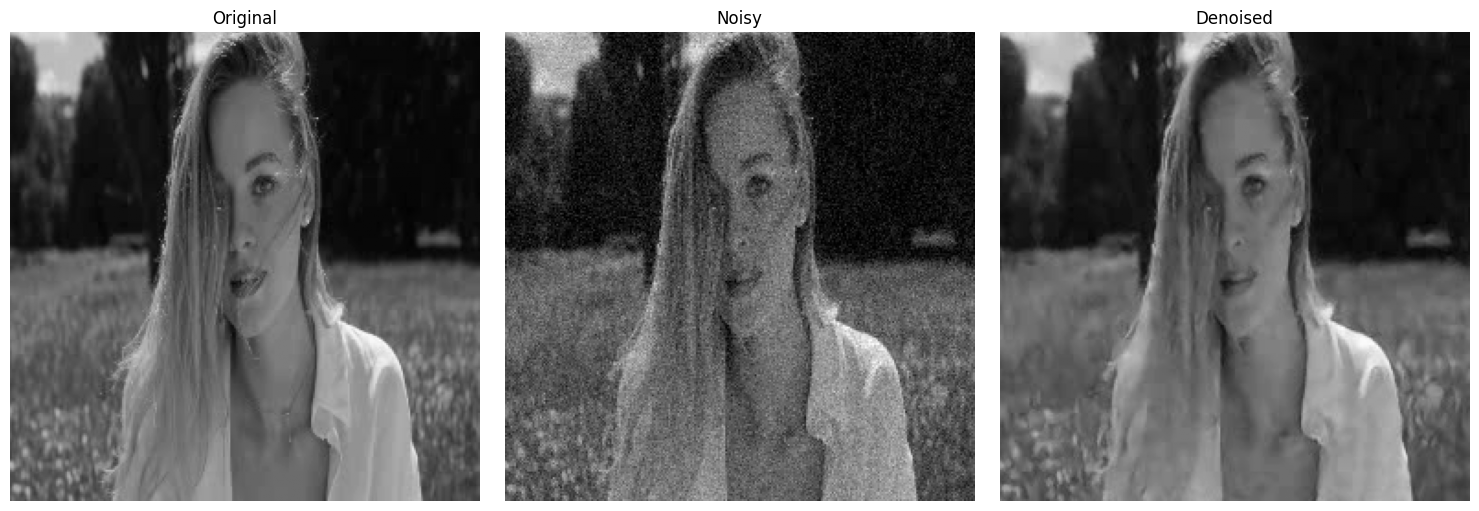

In [12]:
import cv2
import matplotlib.pyplot as plt

# Paths to your videos
original_path = "/content/drive/MyDrive/clean_video_bw.mp4"
noisy_path = "/content/drive/MyDrive/noisy_video_bw.mp4"
denoised_path = "/content/drive/MyDrive/denoised_video_bw.mp4"

def read_first_grayscale_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Could not read frame from: {video_path}")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return gray

# Read first frames
frame_original = read_first_grayscale_frame(original_path)
frame_noisy = read_first_grayscale_frame(noisy_path)
frame_denoised = read_first_grayscale_frame(denoised_path)

# Plot all 3 frames side-by-side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(frame_original, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(frame_noisy, cmap='gray')
plt.title("Noisy")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(frame_denoised, cmap='gray')
plt.title("Denoised")
plt.axis('off')

plt.tight_layout()
plt.show()



In [13]:

# Print average PSNR
avg_psnr_clean_noisy = np.mean(psnr_clean_noisy)
avg_psnr_clean_denoised = np.mean(psnr_clean_denoised)
print(f"Average PSNR (Clean vs Noisy): {avg_psnr_clean_noisy:.2f} dB")
print(f"Average PSNR (Clean vs Denoised): {avg_psnr_clean_denoised:.2f} dB")
print(f"Grayscale videos and plots saved to {output_dir}")

Average PSNR (Clean vs Noisy): 24.86 dB
Average PSNR (Clean vs Denoised): 28.88 dB
Grayscale videos and plots saved to /content/drive/MyDrive/


In [14]:
import random
import pandas as pd
from skimage.metrics import structural_similarity as ssim_func  # For SSIM
from PIL import Image as PILImage
import seaborn as sns
sns.set_style("whitegrid")

In [21]:
# Parameters
num_frames_to_analyze = 10
video_path = input_video_path
output_dir = '/content/drive/MyDrive/denoising_video_samples'
graph_dir = os.path.join(output_dir, 'video_frame_plots')
os.makedirs(graph_dir, exist_ok=True)
dpi = 300

In [22]:
# Re-open video
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
selected_indices = sorted(random.sample(range(frame_count), min(num_frames_to_analyze, frame_count)))
print(f"Analyzing {len(selected_indices)} random frames from video (indices: {selected_indices})")

Analyzing 10 random frames from video (indices: [85, 154, 241, 303, 320, 357, 363, 426, 429, 475])


Frame 86 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


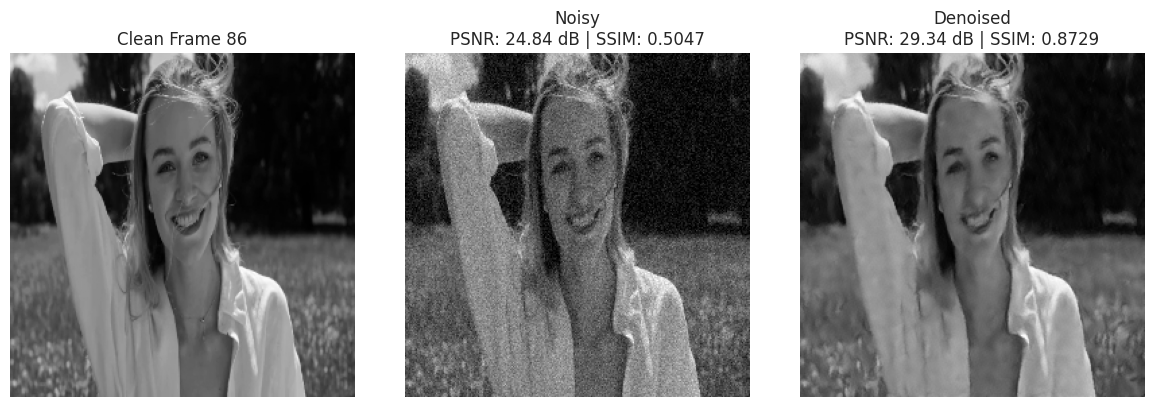

✅ Saved & Displayed triplet for frame 86: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_86.png
Frame 155 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


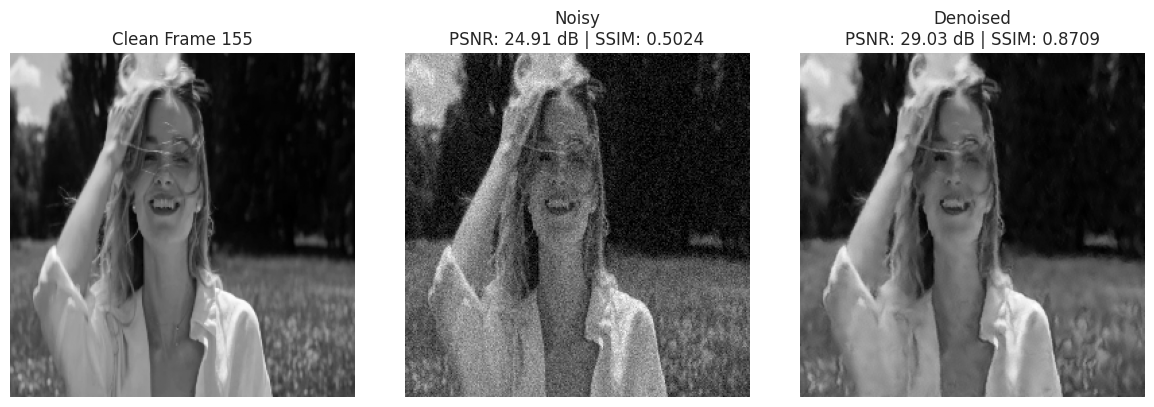

✅ Saved & Displayed triplet for frame 155: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_155.png
Frame 242 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


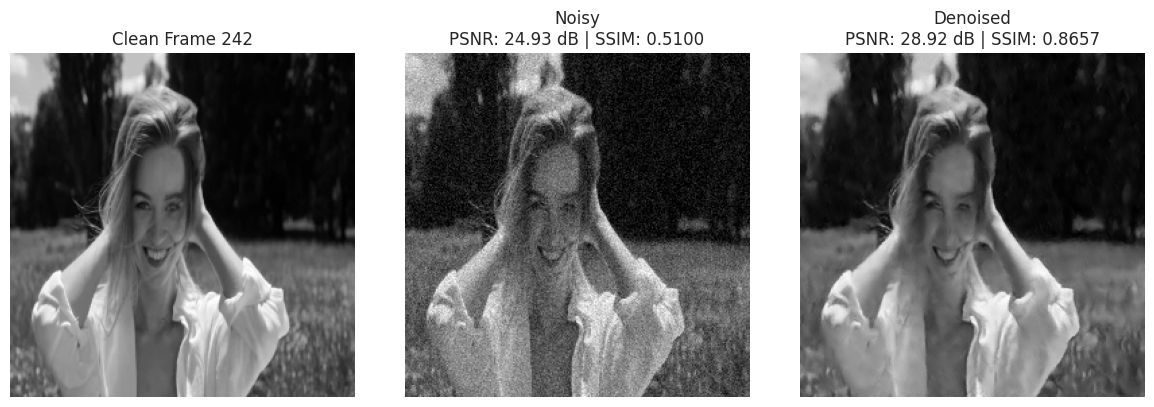

✅ Saved & Displayed triplet for frame 242: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_242.png
Frame 304 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


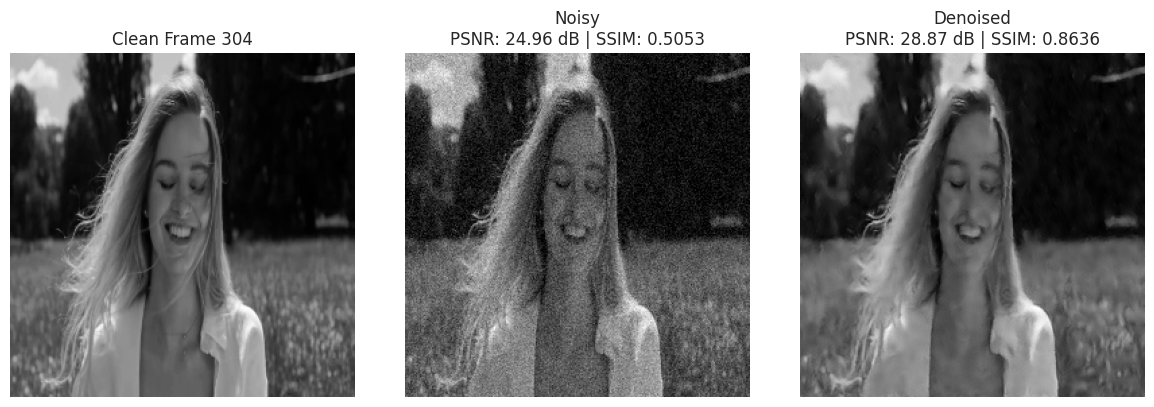

✅ Saved & Displayed triplet for frame 304: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_304.png
Frame 321 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


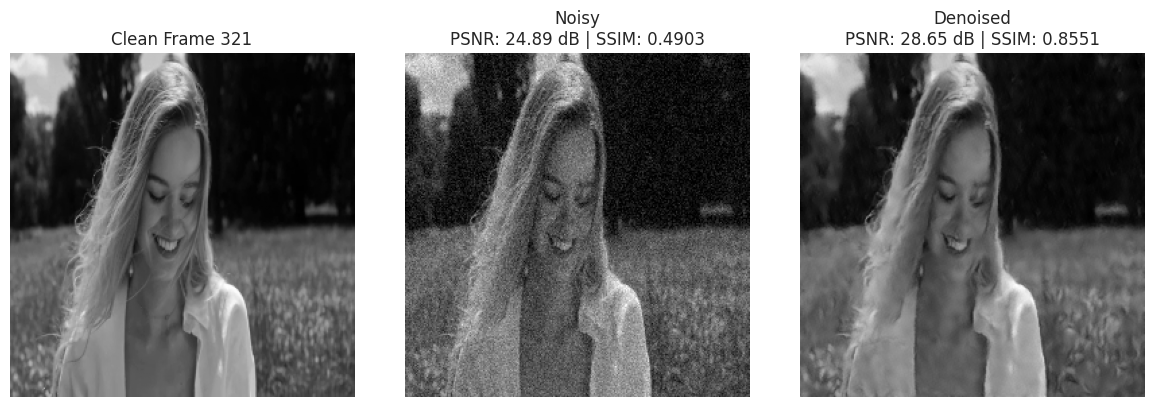

✅ Saved & Displayed triplet for frame 321: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_321.png
Frame 358 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


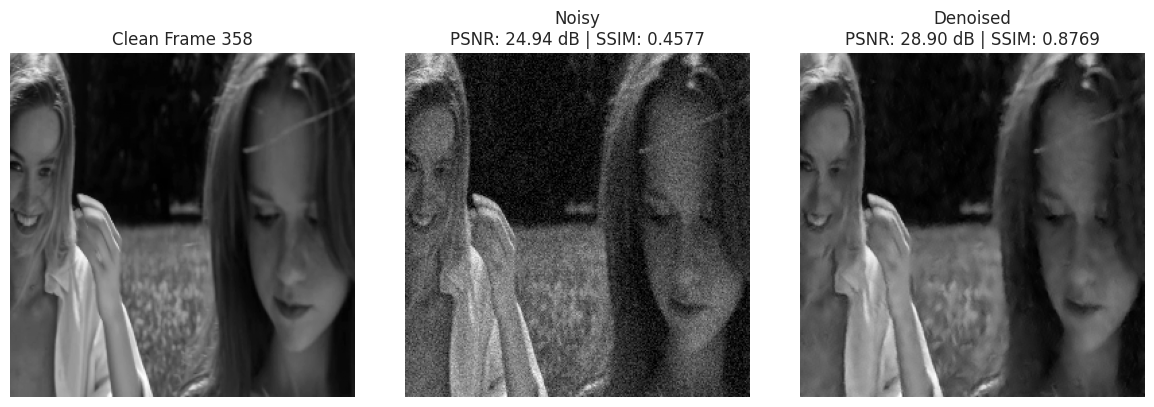

✅ Saved & Displayed triplet for frame 358: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_358.png
Frame 364 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


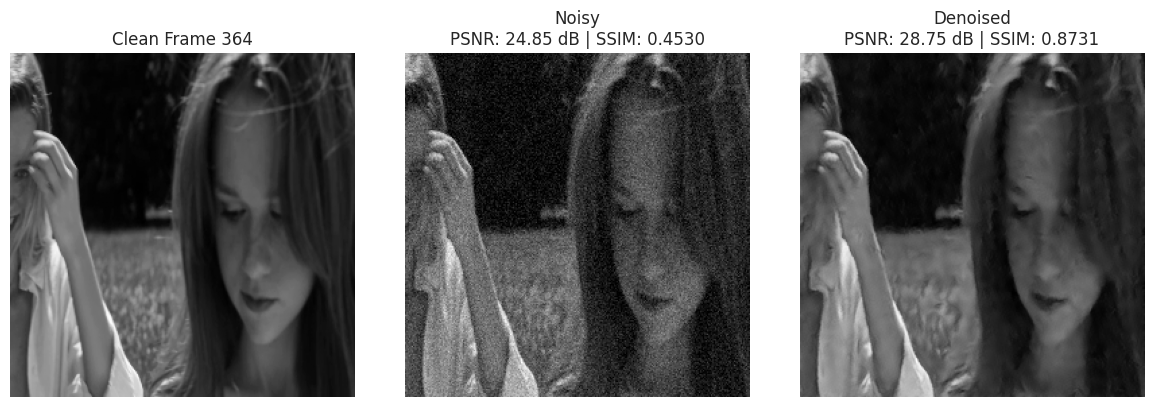

✅ Saved & Displayed triplet for frame 364: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_364.png
Frame 427 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


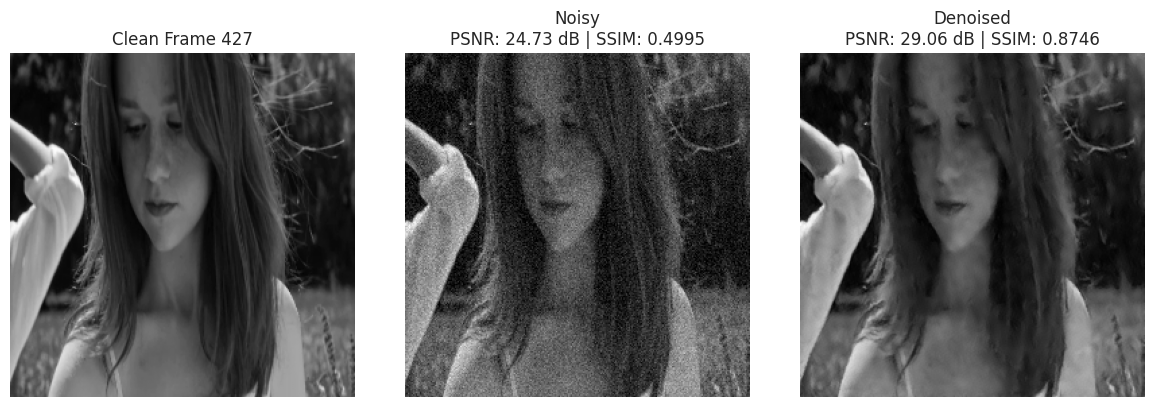

✅ Saved & Displayed triplet for frame 427: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_427.png
Frame 430 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


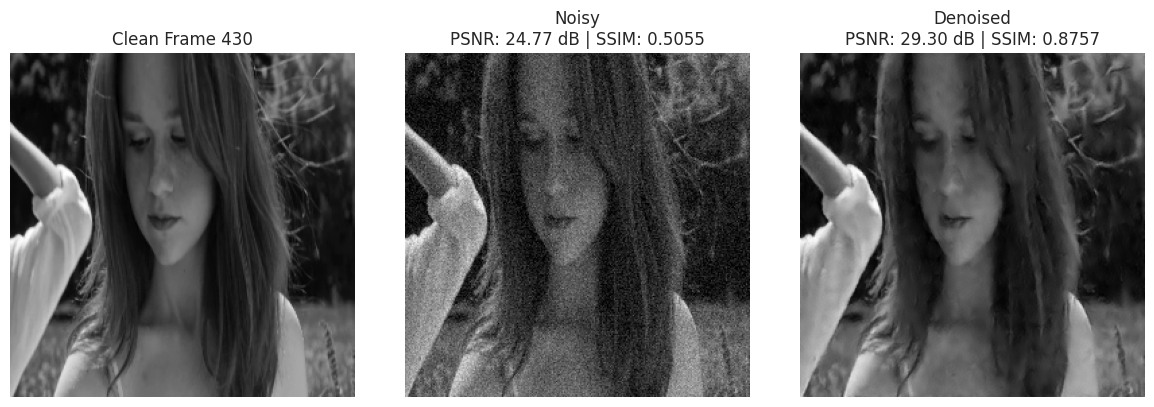

✅ Saved & Displayed triplet for frame 430: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_430.png
Frame 476 shapes: clean (256, 256), noisy (256, 256), denoised (256, 256)


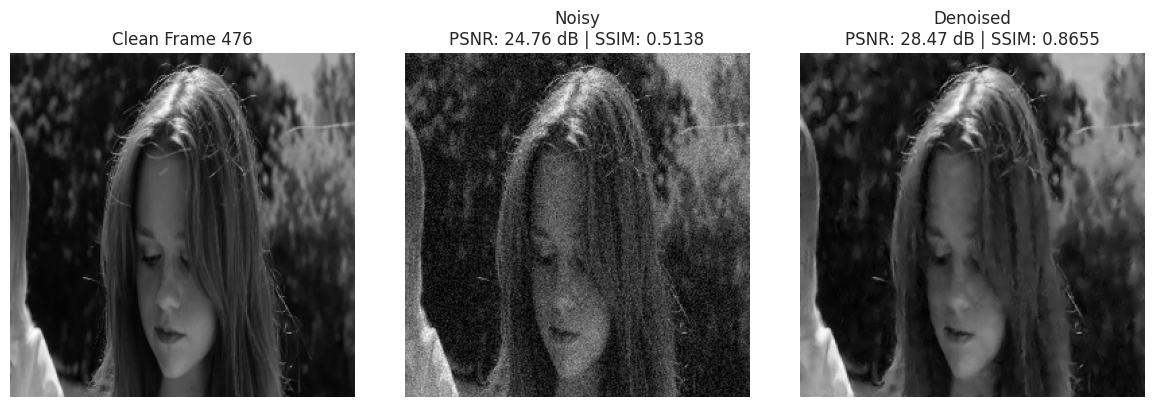

✅ Saved & Displayed triplet for frame 476: /content/drive/MyDrive/denoising_video_samples/video_frame_triplet_476.png


In [23]:
# Lists for metrics
frame_ids = []
psnr_clean_noisy_list = []
psnr_clean_denoised_list = []
ssim_clean_noisy_list = []
ssim_clean_denoised_list = []
triplet_paths = []

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
current_frame = 0
for idx in selected_indices:
    while current_frame < idx:
        ret, _ = cap.read()
        if not ret:
            break
        current_frame += 1

    ret, frame = cap.read()
    if not ret:
        print(f"Warning: Could not read frame {idx}")
        continue
    current_frame += 1

    # Resize to 256x256
    frame = cv2.resize(frame, (256, 256))
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_pil = PILImage.fromarray(frame_rgb)
    frame_tensor = transform(frame_pil).unsqueeze(0).to(device)  # (1,1,H,W)

    # Add noise (expects (1,H,W), so squeeze batch)
    noisy_frame_tensor = add_gaussian_noise(frame_tensor.squeeze(0)).unsqueeze(0)  # (1,1,H,W)

    # Denoise
    with torch.no_grad(), autocast(device_type='cuda'):
        denoised_frame = model(noisy_frame_tensor).squeeze(0)  # (1,H,W)

    # To NumPy - FIXED: Ensure 2D grayscale (H,W)
    clean_np = frame_tensor.squeeze().cpu().numpy()  # squeeze all -> (H,W)
    noisy_np = noisy_frame_tensor.squeeze().cpu().numpy()  # squeeze all -> (H,W)
    denoised_np = denoised_frame.squeeze().cpu().numpy()  # (H,W)

    # Verify shapes (debug)
    print(f"Frame {idx+1} shapes: clean {clean_np.shape}, noisy {noisy_np.shape}, denoised {denoised_np.shape}")

    # Compute PSNR and SSIM (now 2D arrays)
    psnr_cn = peak_signal_noise_ratio(clean_np, noisy_np, data_range=1.0)
    psnr_cd = peak_signal_noise_ratio(clean_np, denoised_np, data_range=1.0)
    ssim_cn = ssim_func(clean_np, noisy_np, data_range=1.0, win_size=7)
    ssim_cd = ssim_func(clean_np, denoised_np, data_range=1.0, win_size=7)

    # Store
    frame_ids.append(idx + 1)
    psnr_clean_noisy_list.append(psnr_cn)
    psnr_clean_denoised_list.append(psnr_cd)
    ssim_clean_noisy_list.append(ssim_cn)
    ssim_clean_denoised_list.append(ssim_cd)

    # Save and DISPLAY triplet (3 images: clean-noisy-denoised)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(clean_np, cmap='gray')
    axes[0].set_title(f"Clean Frame {idx+1}")
    axes[0].axis('off')

    axes[1].imshow(noisy_np, cmap='gray')
    axes[1].set_title(f"Noisy\nPSNR: {psnr_cn:.2f} dB | SSIM: {ssim_cn:.4f}")
    axes[1].axis('off')

    axes[2].imshow(denoised_np, cmap='gray')
    axes[2].set_title(f"Denoised\nPSNR: {psnr_cd:.2f} dB | SSIM: {ssim_cd:.4f}")
    axes[2].axis('off')

    plt.tight_layout()
    triplet_path = os.path.join(output_dir, f'video_frame_triplet_{idx+1}.png')
    plt.savefig(triplet_path, dpi=150, bbox_inches='tight')
    plt.show()  # Display in Colab
    plt.close()
    triplet_paths.append(triplet_path)
    print(f"✅ Saved & Displayed triplet for frame {idx+1}: {triplet_path}")

cap.release()

In [24]:
# ==== Metrics Table ====
df = pd.DataFrame({
    'Frame_ID': frame_ids,
    'PSNR_Clean_Noisy_dB': psnr_clean_noisy_list,
    'PSNR_Clean_Denoised_dB': psnr_clean_denoised_list,
    'SSIM_Clean_Noisy': ssim_clean_noisy_list,
    'SSIM_Clean_Denoised': ssim_clean_denoised_list,
    'PSNR_Improvement_dB': np.array(psnr_clean_denoised_list) - np.array(psnr_clean_noisy_list),
    'SSIM_Improvement': np.array(ssim_clean_denoised_list) - np.array(ssim_clean_noisy_list)
})

In [25]:
# Aggregates
agg_row = pd.DataFrame({
    'Frame_ID': ['Aggregate'],
    'PSNR_Clean_Noisy_dB': [np.mean(psnr_clean_noisy_list)],
    'PSNR_Clean_Denoised_dB': [np.mean(psnr_clean_denoised_list)],
    'SSIM_Clean_Noisy': [np.mean(ssim_clean_noisy_list)],
    'SSIM_Clean_Denoised': [np.mean(ssim_clean_denoised_list)],
    'PSNR_Improvement_dB': [np.mean(np.array(psnr_clean_denoised_list) - np.array(psnr_clean_noisy_list))],
    'SSIM_Improvement': [np.mean(np.array(ssim_clean_denoised_list) - np.array(ssim_clean_noisy_list))]
})
df_full = pd.concat([df, agg_row], ignore_index=True)

In [26]:
# Export
table_path = os.path.join(output_dir, 'video_frame_metrics_table.csv')
df_full.to_csv(table_path, index=False)
df_full.to_latex(os.path.join(output_dir, 'video_frame_metrics_table.tex'), index=False, escape=False)
print(f"\n📊 Video Frame Metrics Table:\n{df_full.round(4)}")
print(f"CSV: {table_path} | LaTeX: {os.path.join(output_dir, 'video_frame_metrics_table.tex')}")


📊 Video Frame Metrics Table:
     Frame_ID  PSNR_Clean_Noisy_dB  PSNR_Clean_Denoised_dB  SSIM_Clean_Noisy  \
0          86              24.8409                 29.3395            0.5047   
1         155              24.9058                 29.0302            0.5024   
2         242              24.9319                 28.9210            0.5100   
3         304              24.9632                 28.8700            0.5053   
4         321              24.8869                 28.6505            0.4903   
5         358              24.9395                 28.9001            0.4577   
6         364              24.8530                 28.7470            0.4530   
7         427              24.7264                 29.0606            0.4995   
8         430              24.7738                 29.2979            0.5055   
9         476              24.7608                 28.4723            0.5138   
10  Aggregate              24.8582                 28.9289            0.4942   

    SSIM_


📈 Generating grouped bar graph for PSNR across 10 frames...


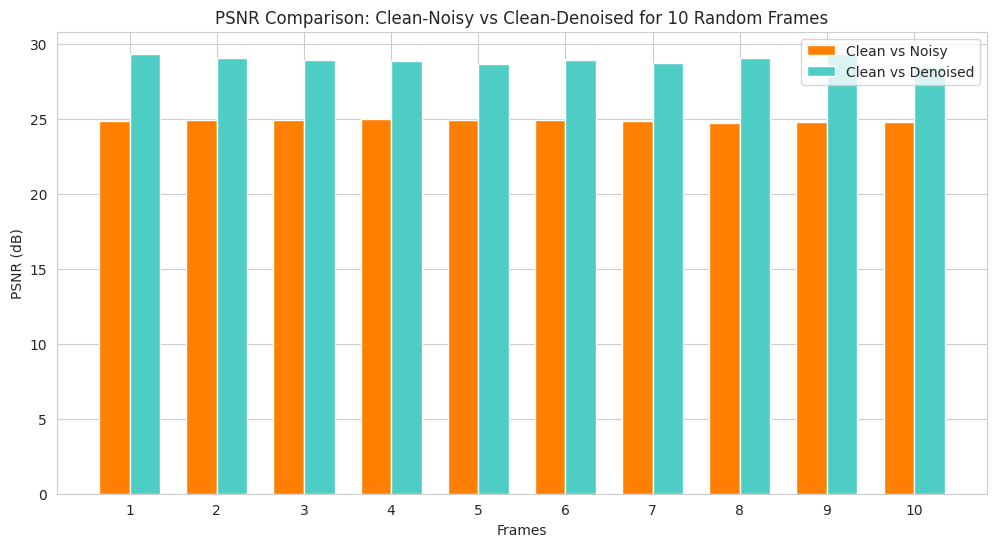

In [34]:
# Grouped bar graph for PSNR across 10 frames
print("\n📈 Generating grouped bar graph for PSNR across 10 frames...")
num_samples = len(psnr_clean_denoised_list)  # Should be 10
samples = [str(i+1) for i in range(num_samples)]
x = np.arange(len(samples))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, psnr_clean_noisy_list, width, label='Clean vs Noisy', color = '#FF7F00')
bars2 = ax.bar(x + width/2, psnr_clean_denoised_list, width, label='Clean vs Denoised', color='#4ECDC4')

ax.set_xlabel('Frames')
ax.set_ylabel('PSNR (dB)')
ax.set_title('PSNR Comparison: Clean-Noisy vs Clean-Denoised for 10 Random Frames')
ax.set_xticks(x)
ax.set_xticklabels(samples)
ax.legend()


📈 Generating grouped bar graph for SSIM across 10 frames...


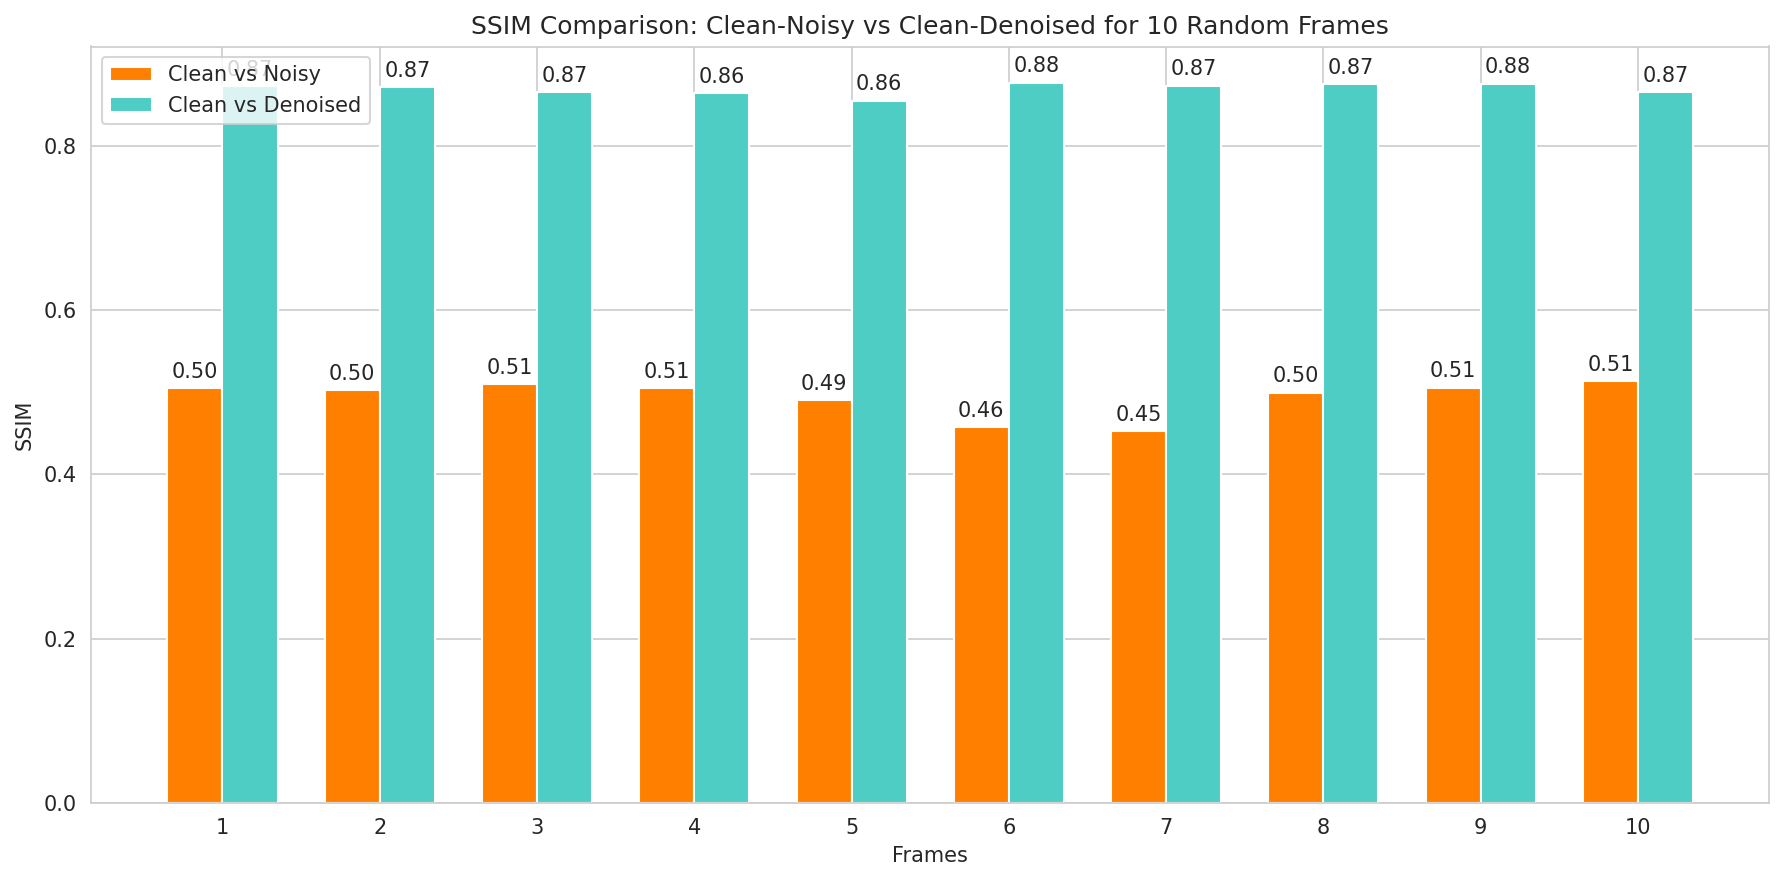

📊 SSIM bar graph saved and displayed: /content/drive/MyDrive/denoising_video_samples/video_ssim_comparison_10_frames.png


<Figure size 640x480 with 0 Axes>

In [39]:
from IPython.display import Image, display
# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
psnr_graph_path = os.path.join(output_dir, 'video_psnr_comparison_10_frames.png')
plt.savefig(psnr_graph_path, dpi=150, bbox_inches='tight')
plt.close(fig)

# Grouped bar graph for SSIM across 10 frames
print("\n📈 Generating grouped bar graph for SSIM across 10 frames...")
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, ssim_clean_noisy_list, width, label='Clean vs Noisy', color='#FF7F00')
bars2 = ax.bar(x + width/2, ssim_clean_denoised_list, width, label='Clean vs Denoised', color='#4ECDC4')

ax.set_xlabel('Frames')
ax.set_ylabel('SSIM')
ax.set_title('SSIM Comparison: Clean-Noisy vs Clean-Denoised for 10 Random Frames')
ax.set_xticks(x)
ax.set_xticklabels(samples)
ax.legend()

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
ssim_graph_path = os.path.join(output_dir, 'video_ssim_comparison_10_frames.png')
plt.savefig(ssim_graph_path, dpi=150, bbox_inches='tight')
plt.close(fig)

# Display the SSIM bar graph
display(Image(filename=ssim_graph_path))
print(f"📊 SSIM bar graph saved and displayed: {ssim_graph_path}")